In [ ]:
import re
import spacy
import requests
import pandas as pd
from bs4 import BeautifulSoup
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# get text from html and parse it
response = requests.get('http://www.bbc.com/news')
doc = BeautifulSoup(response.text, 'html.parser')
headlines = doc.find_all('h3')
stories_list = []

for headline in headlines:
    print(headline.text)
    stories_list.append(headline.text)

# Now that we're done, convert to a CSV and save.
# If you don't use index=False, you'll get an ugly dataframe!
import pandas as pd
df = pd.DataFrame(stories_list)
df.to_csv("bbc.csv", index=False)

From Kabul and beyond, a year of Taliban rule
From Kabul and beyond, a year of Taliban rule
We saved who we could - Egypt church fire survivor
'Just weird': Ex-Australian PM held 'secret roles'
Remote Pacific nation hit by first Covid outbreak
Ecuador blast 'declaration of war' by gangs
Russia vows to expand relations with North Korea
Fireworks explosion rocks Armenia shopping market
Kenya set to announce presidential election result
World leaders meet in attempt to protect oceans
Rushdie's 'defiant sense of humour' remains - son
Walrus Freya who became Oslo attraction put down
Rushdie's 'defiant sense of humour' remains - son
Walrus Freya who became Oslo attraction put down
Sprinter pulled over for second time by police
Russia reopens bond market to friendly traders
Saudi oil giant breaks profit record with $48.4bn
The Taliban's broken promises
Former Afghan leaders mark year of Taliban rule
We fled the Taliban for our Olympic dream
The librarian who defied the Taliban
The Taliban sni

In [ ]:
# import wikipedia sentences, they have 4318 rows
headlines = pd.read_csv("bbc.csv")
headlines.shape

(47, 1)

In [ ]:
headlines

,0
0,"From Kabul and beyond, a year of Taliban rule"
1,"From Kabul and beyond, a year of Taliban rule"
2,We saved who we could - Egypt church fire survivor
3,'Just weird': Ex-Australian PM held 'secret roles'
4,Remote Pacific nation hit by first Covid outbreak
5,Ecuador blast 'declaration of war' by gangs
6,Russia vows to expand relations with North Korea
7,Fireworks explosion rocks Armenia shopping market
8,Kenya set to announce presidential election result
9,World leaders meet in attempt to protect oceans


In [ ]:
# exact sentence example
nlp = spacy.load('en_core_web_sm')

doc = nlp("Salman Rushdie: The writer who emerged from hiding")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Salman ... compound
Rushdie ... ROOT
: ... punct
The ... det
writer ... appos
who ... nsubj
emerged ... relcl
from ... prep
hiding ... pobj


In [ ]:
def get_entities(sent):

  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
   #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("Salman Rushdie: The writer who emerged from hiding.")

['Salman who', 'hiding']

In [ ]:
entity_pairs = []

In [ ]:
entity_pairs[10:20]

[]

In [ ]:
entity_pairs

[]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
# verb
get_relation("Salman Rushdie: The writer who emerged from hiding.")

'Rushdie'

In [ ]:
# the column name is 0
relations = [get_relation(i) for i in tqdm(headlines['0'])]

100%|██████████| 47/47 [00:00<00:00, 121.91it/s]


In [ ]:
entity_pairs = []

for i in tqdm(headlines["0"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 47/47 [00:00<00:00, 130.01it/s]


In [ ]:
entity_pairs[10:20]

[['', 'defiant  remains'],
 ['who', ''],
 ['', 'defiant  remains'],
 ['who', ''],
 ['Sprinter', 'second  police'],
 ['Russia', 'friendly bond traders'],
 ['Saudi oil giant', '$ profit 48.4bn'],
 ['', ''],
 ['Afghan  leaders', 'Taliban rule'],
 ['We', 'Olympic  dream']]

In [ ]:
kg_df.head()

,source,target,edge
0,,year Taliban rule,From
1,,year Taliban rule,From
2,We,who church fire survivor,saved
3,Australian Ex PM,secret roles,weird
4,,Covid Remote Pacific outbreak,nation


In [ ]:
kg_df

,source,target,edge
0,,year Taliban rule,From
1,,year Taliban rule,From
2,We,who church fire survivor,saved
3,Australian Ex PM,secret roles,weird
4,,Covid Remote Pacific outbreak,nation
5,,Ecuador gangs,declaration of
6,Russia,North Korea,vows
7,Fireworks explosion,Armenia shopping market,rocks
8,Kenya,presidential election result,set
9,World leaders,oceans,meet in


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# verb count
pd.Series(relations).value_counts()[:50]

From                 2
sense of             2
put                  2
Fear in              1
Pulling              1
baggage for young    1
powered              1
tech                 1
partitioned          1
haunts black         1
story                1
performers           1
end of               1
won                  1
genius               1
homes of             1
novel of             1
way                  1
problem for          1
town                 1
newsletter           1
app                  1
waiting for          1
wiped                1
saved                1
Radio                1
weird                1
nation               1
declaration of       1
vows                 1
rocks                1
set                  1
meet in              1
pulled               1
reopens              1
breaks               1
promises             1
mark                 1
fled                 1
librarian            1
working behind       1
defiant              1
TV                   1
Get in     

In [ ]:
import nltk  

textsample ="Kenya elections 2022: Live result updates. King Goat removed from 'throne' as Irish heat soars. Kenya elections 2022: Live result updates. Drought on the Rhine: 'We have 30cm of water left'. Hacking not behind Kenya’s slow count - commission. Nuclear warning and clean-up raves - Ukraine round-up."  

sentences = nltk.sent_tokenize(textsample)  
words = nltk.word_tokenize(textsample)  
sentences 
[w for w in words if w.isalpha()]

['Kenya',
 'elections',
 'Live',
 'result',
 'updates',
 'King',
 'Goat',
 'removed',
 'from',
 'as',
 'Irish',
 'heat',
 'soars',
 'Kenya',
 'elections',
 'Live',
 'result',
 'updates',
 'Drought',
 'on',
 'the',
 'Rhine',
 'have',
 'of',
 'water',
 'left',
 'Hacking',
 'not',
 'behind',
 'Kenya',
 's',
 'slow',
 'count',
 'commission',
 'Nuclear',
 'warning',
 'and',
 'raves',
 'Ukraine']

In [ ]:
sentences

['Kenya elections 2022: Live result updates.',
 "King Goat removed from 'throne' as Irish heat soars.",
 'Kenya elections 2022: Live result updates.',
 "Drought on the Rhine: 'We have 30cm of water left'.",
 'Hacking not behind Kenya’s slow count - commission.',
 'Nuclear warning and clean-up raves - Ukraine round-up.']

In [ ]:
a_list = nltk.tokenize.sent_tokenize(textsample)

In [ ]:
print(a_list)

['Kenya elections 2022: Live result updates.', "King Goat removed from 'throne' as Irish heat soars.", 'Kenya elections 2022: Live result updates.', "Drought on the Rhine: 'We have 30cm of water left'.", 'Hacking not behind Kenya’s slow count - commission.', 'Nuclear warning and clean-up raves - Ukraine round-up.']


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# Make a search with the Wikipedia API

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

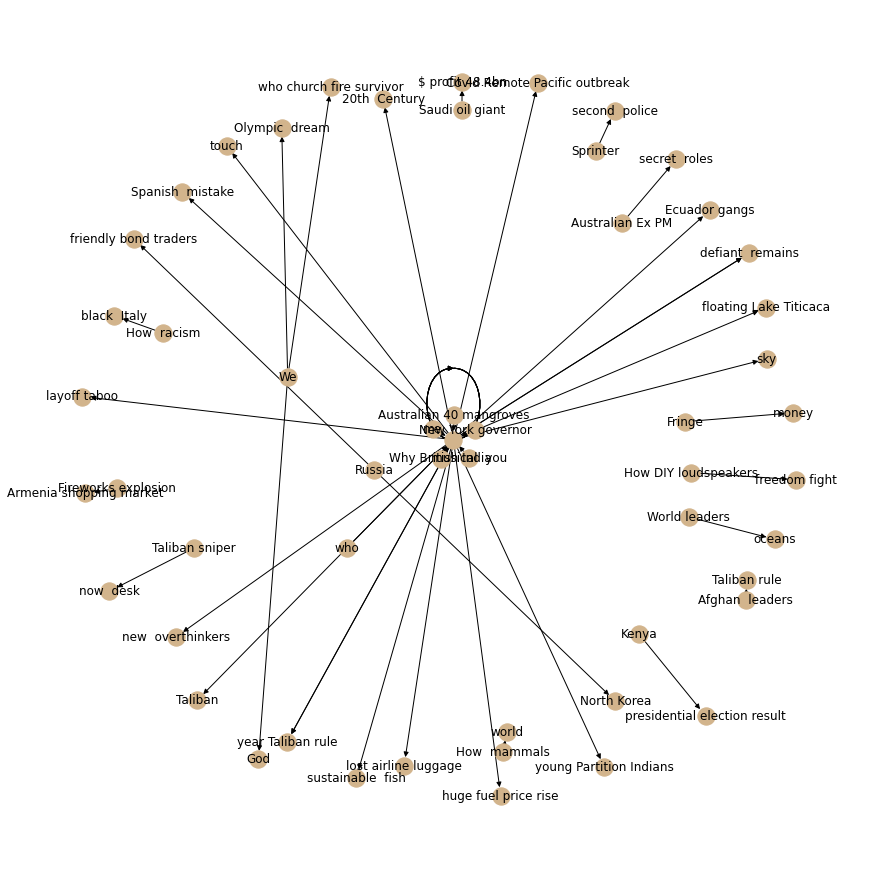

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='tan', edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

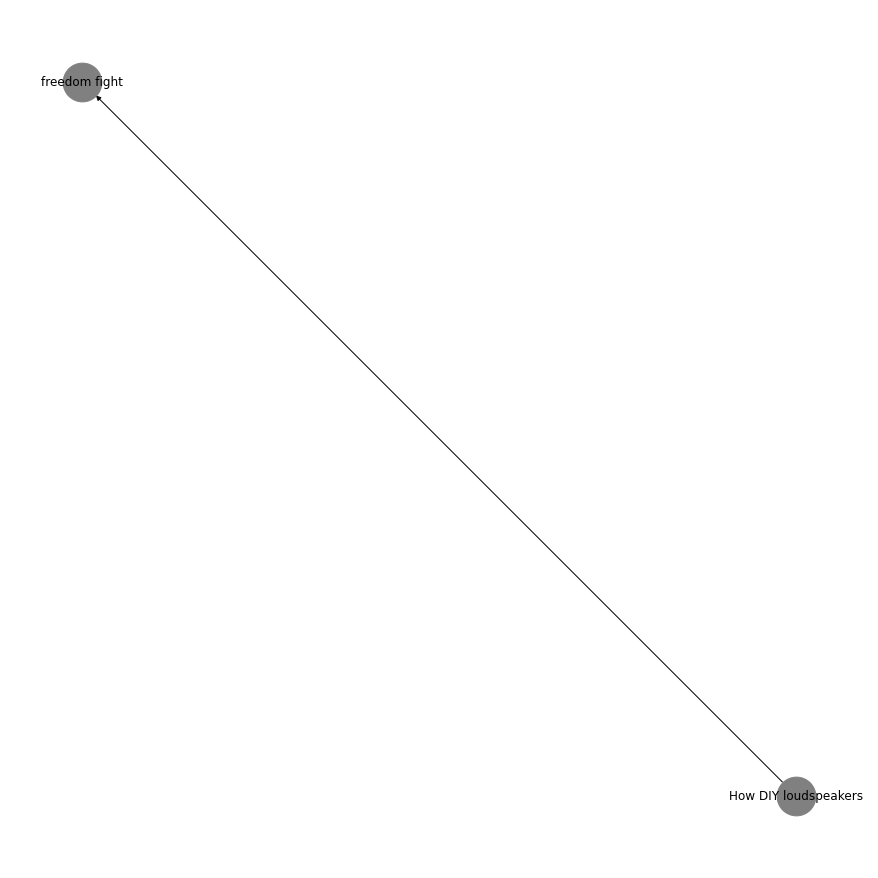

In [ ]:
H=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="powered"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, k = 0.9) # k regulates the distance between nodes
nx.draw(H, with_labels=True, node_color='grey', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

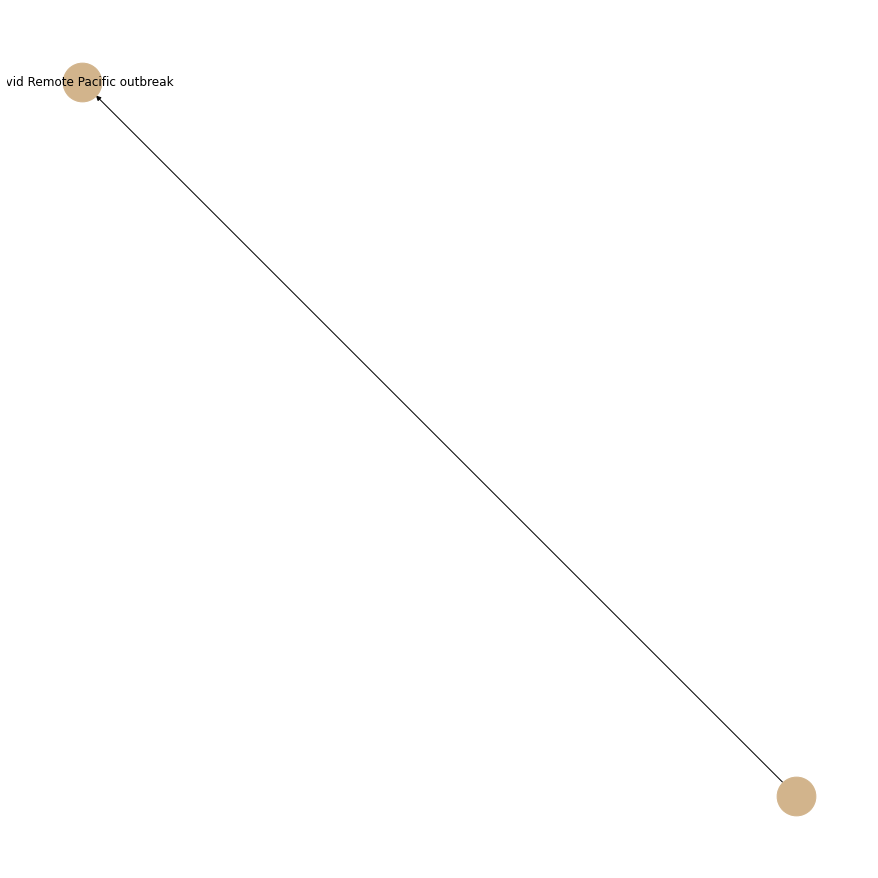

In [ ]:
I=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="nation"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(I, k = 0.5)
nx.draw(I, with_labels=True, node_color='tan', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

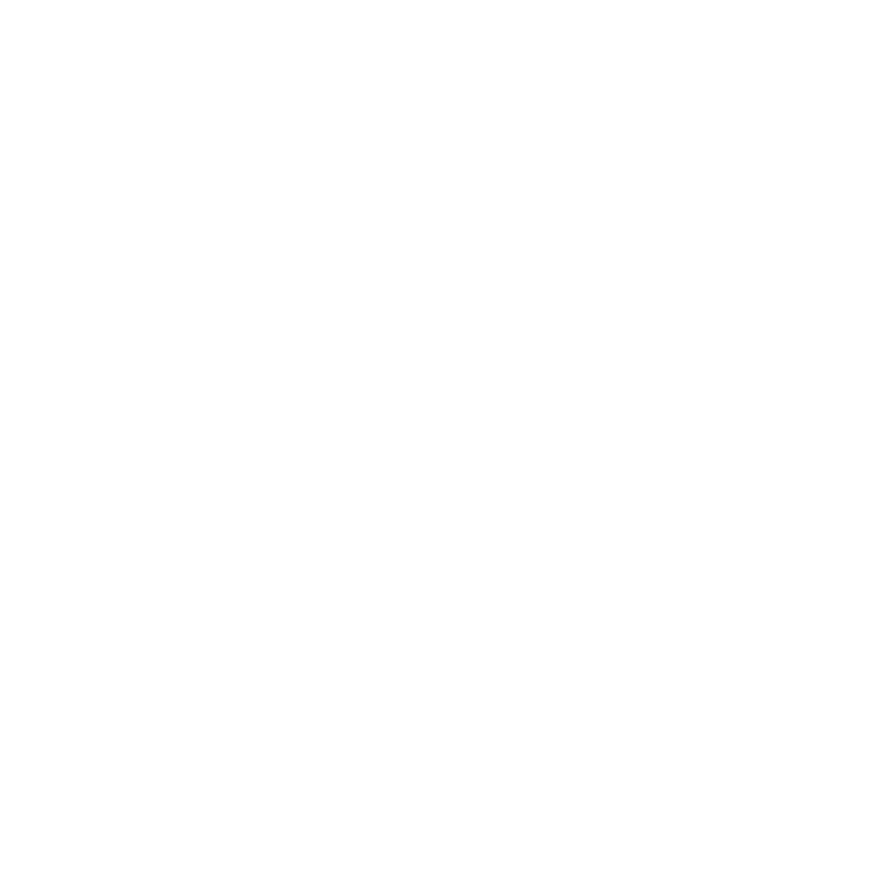

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="pull"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='silver', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

In [ ]:
nltk.download('punkt')
text2 = "BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage. The service maintains 50 foreign news bureaus with more than 250 correspondents around the world. Fran Unsworth has been director of news and current affairs since January 2018. In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019. BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London. Parliamentary coverage is produced and broadcast from studios in London. Through BBC English Regions, the BBC also has regional centres across England and national news centres in Northern Ireland, Scotland and Wales. All nations and English regions produce their own local news programmes and other current affairs and sport programmes."
print(text2)

BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage. The service maintains 50 foreign news bureaus with more than 250 correspondents around the world. Fran Unsworth has been director of news and current affairs since January 2018. In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019. BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London. Parliamentary coverage is produced and broadcast from studios in London. Through BBC English Regions, the BBC also has regional centres across England and national news centres in North

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sentences2 = nltk.sent_tokenize(text2)  
words2 = nltk.word_tokenize(text2)  

In [ ]:
sentences2

['BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world.',
 "The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.",
 'The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.',
 'Fran Unsworth has been director of news and current affairs since January 2018.',
 'In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019.',
 'BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London.',
 'Parliamentary coverage is produced and broadcast from studios in London.',
 'Through BBC English Regions, the BBC also has regional centres across England and 

In [ ]:
df = pd.DataFrame(sentences2)
df.to_csv("s2.csv", index=False)

In [71]:
pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 14.9 MB/s 


In [72]:
import PyPDF2

In [78]:
pdfFileObj = open('Multilingual.pdf', 'rb') 
    
# creating a pdf reader object 
pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    
# printing number of pages in pdf file 
print(pdfReader.numPages) 
    
# creating a page object 
pageObj = pdfReader.getPage(0) 

19


In [79]:
# extracting text from page 
print(pageObj.extractText()) 

Undeﬁned 0 (0) 1 1
IOS Press
Multilingual Linked Open Data Patterns
Jose Emilio Labra Gayoa;, Dimitris Kontokostasband Sören Auerb
aDepartment of Computer Science. University of Oviedo, CP. 33007, Oviedo, Spain
Email: labra@uniovi.es
bUniversität Leipzig, Institut für Informatik, AKSW, Postfach 100920, 04009 Leipzig, Germany
E-mail: {lastname}@informatik.uni-leipzig.de
Abstract. The increasing publication of linked data makes the vision of the semantic web a probable reality .
Although it may seem that the web of data is inherently multilingual, data usually contains labels, comments,
descriptions, etc. that depend on the natural language used. When linked data appears in a multilingual setting,
it is a challenge to publish and consume it. This paper presents a survey of patterns and best practices to publish
Multilingual Linked Data and identiﬁes some issues that should be taken into account. As a use case, the paper
describes the patterns employed in the DBpedia Internationalization

In [84]:
a=pdfReader.getPage(2).extractText()

In [88]:
a

'J. Labra et al / Multilingual LOD Patterns 3\nIn the case of the W eb architecture, the solution\nadopted was Normalization F orm Canonical Com-\nposition (NFC) and is described in [ 3]. The use of\nnormalization is important for linked data as it is\nnecessary to have a non-ambiguous way to check\nif two identiﬁers are the same.\n2.2. URIs and IRIs\nOne of the cornerstones of W eb architecture is\nthe use of Uniform Resource Identiﬁers (URIs) [ 8]\nto identify any kind of resource. URIs were for-\nmally described by the IETF RFC 3986 [ 11 ] and\ntheir design oﬀered a trade-oﬀ solution between\nreadability and usability .\nThe readability goal can be achieved when URIs\nare easily remembered and interpreted by people,\nemploying meaningful or familiar components. T o\nthat end, people from non-Latin alphabets should\nbe allowed to use their own alphabets (i.e. Unicode\ncharacters) in their URIs. However, due to the\nusability design trade-oﬀ, the URI speciﬁcation\nrestricted the chara

In [89]:
sentences3 = nltk.sent_tokenize(a) 

In [90]:
sentences3

['J. Labra et al / Multilingual LOD Patterns 3\nIn the case of the W eb architecture, the solution\nadopted was Normalization F orm Canonical Com-\nposition (NFC) and is described in [ 3].',
 'The use of\nnormalization is important for linked data as it is\nnecessary to have a non-ambiguous way to check\nif two identiﬁers are the same.',
 '2.2.',
 'URIs and IRIs\nOne of the cornerstones of W eb architecture is\nthe use of Uniform Resource Identiﬁers (URIs) [ 8]\nto identify any kind of resource.',
 'URIs were for-\nmally described by the IETF RFC 3986 [ 11 ] and\ntheir design oﬀered a trade-oﬀ solution between\nreadability and usability .',
 'The readability goal can be achieved when URIs\nare easily remembered and interpreted by people,\nemploying meaningful or familiar components.',
 'T o\nthat end, people from non-Latin alphabets should\nbe allowed to use their own alphabets (i.e.',
 'Unicode\ncharacters) in their URIs.',
 'However, due to the\nusability design trade-oﬀ, the URI spe